<a href="https://colab.research.google.com/github/fabehashahzad/CNN-model-on-cifar-10/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Classify MINI CIFAR-10 dataset with VGG16 architecture by training for 30 epochs.

# **1) IMPORTING LIBRARIES**

In [1]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow.keras as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score


# **2) DOWNLOADING VGG16 ARCHITECTURE**

In [2]:
vgg16_model = VGG16(weights='imagenet',
                    include_top=False,
                    classes=10,
                    input_shape=(32,32,3)# input: 32x32 images with 3 channels -> (32, 32, 3) tensors.
                   )

58889256/58889256 [==============================] - 4s 0us/step


In [24]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)


In [25]:

from tensorflow.keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax', name='predictions'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

# **3) IMPORTING CIFAR10 DATASET**

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split


# Load the CIFAR-10 dataset
(x_train, y_train), (_, _) = cifar10.load_data()

# Choose first 150 images in each class
num_classes = 10
num_images_per_class = 150

mini_dataset = []
mini_labels = []

for class_label in range(num_classes):
    class_indices = np.where(y_train[:, 0] == class_label)[0]
    selected_indices = class_indices[:num_images_per_class]
    mini_dataset.append(x_train[selected_indices])
    mini_labels.extend([class_label] * num_images_per_class)

# Convert lists to NumPy arrays
mini_dataset = np.concatenate(mini_dataset, axis=0)
mini_labels = np.array(mini_labels)

# Split the MINI CIFAR-10 dataset into train (60%), valid (20%), and test (20%) sets with equal class distribution
x_train_mini, x_temp, y_train_mini, y_temp = train_test_split(
    mini_dataset, mini_labels, test_size=0.4, random_state=42, stratify=mini_labels
)
x_valid_mini, x_test_mini, y_valid_mini, y_test_mini = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Print shapes of the resulting sets
print("Train set shape:", x_train_mini.shape)
print("Valid set shape:", x_valid_mini.shape)
print("Test set shape:", x_test_mini.shape)


170498071/170498071 [==============================] - 13s 0us/step
Train set shape: (900, 32, 32, 3)
Valid set shape: (300, 32, 32, 3)
Test set shape: (300, 32, 32, 3)


In [4]:
# Print shapes of the resulting sets
print("Train set shape:", x_train_mini.shape)
print("Valid set shape:", x_valid_mini.shape)
print("Test set shape:", x_test_mini.shape)
print("Train set shape:", y_train_mini.shape)
print("Valid set shape:", y_valid_mini.shape)
print("Test set shape:", y_test_mini.shape)

Train set shape: (900, 32, 32, 3)
Valid set shape: (300, 32, 32, 3)
Test set shape: (300, 32, 32, 3)
Train set shape: (900,)
Valid set shape: (300,)
Test set shape: (300,)


# **4) DATA PREPROCESSING**

In [5]:
# Convert class vectors to binary class matrices using one hot encoding
y_train_mini = to_categorical(y_train_mini, num_classes = 10)
y_test_mini = to_categorical(y_test_mini, num_classes = 10)
y_valid_mini = to_categorical(y_valid_mini, num_classes = 10)

In [6]:
# Data normalization
x_train_mini = x_train_mini.astype('float32')
x_test_mini = x_test_mini.astype('float32')
x_valid_mini = x_valid_mini.astype('float32')
x_train_mini  /= 255
x_test_mini /= 255
x_valid_mini /= 255

# **5) MODEL DEVELOPMENT**

In [13]:
sgd = optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])

In [14]:
def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [16]:
# initialize the number of epochs and batch size
EPOCHS = 30
BS = 64

# train the model
history = model.fit(
    x_train_mini,y_train_mini, batch_size=BS,
    validation_data=(x_valid_mini,y_valid_mini),
    steps_per_epoch=len(x_train_mini) // BS,
    epochs=EPOCHS,
    callbacks=[reduce_lr,mc])

Epoch 1/30
13/14 [==========================>...] - ETA: 0s - loss: 2.4832 - accuracy: 0.1070

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 11s 135ms/step - loss: 2.4792 - accuracy: 0.1060 - val_loss: 2.2548 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 2/30
14/14 [==============================] - 2s 65ms/step - loss: 2.2854 - accuracy: 0.1591 - val_loss: 2.1605 - val_accuracy: 0.2767 - lr: 0.0010
Epoch 3/30
14/14 [==============================] - 1s 66ms/step - loss: 2.1988 - accuracy: 0.1734 - val_loss: 2.0661 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 4/30
14/14 [==============================] - 1s 63ms/step - loss: 2.1071 - accuracy: 0.2189 - val_loss: 1.9584 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 5/30
14/14 [==============================] - 1s 40ms/step - loss: 1.9314 - accuracy: 0.2967 - val_loss: 1.8131 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 6/30
14/14 [==============================] - 1s 39ms/step - loss: 1.9193 - accuracy: 0.2931 - val_loss: 1.8177 - val_accuracy: 0.3633 - lr: 0.0010
Epoch 7/30
14/14 [==============================] - 1s 39ms/step - loss: 1.8432 - acc

# **6) MODEL EVALUATION**

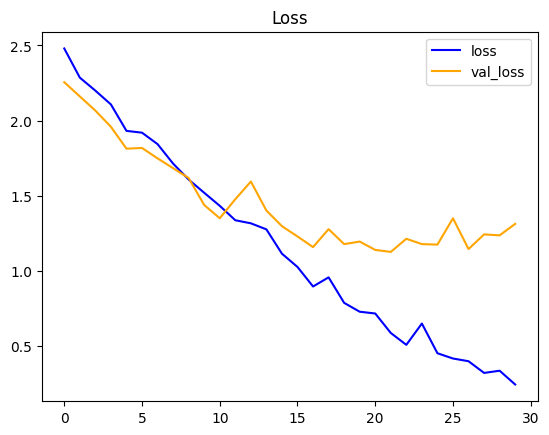

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'], color= 'blue', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label = 'val_loss')
plt.title('Loss')
plt.legend(loc = 'upper right')
plt.show()

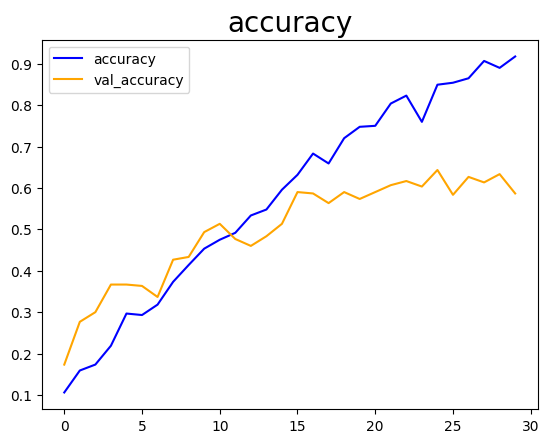

In [18]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color= 'blue', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
plt.title('accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

10/10 [==============================] - 0s 15ms/step - loss: 1.3637 - accuracy: 0.6500
Test accuracy: 0.6499999761581421


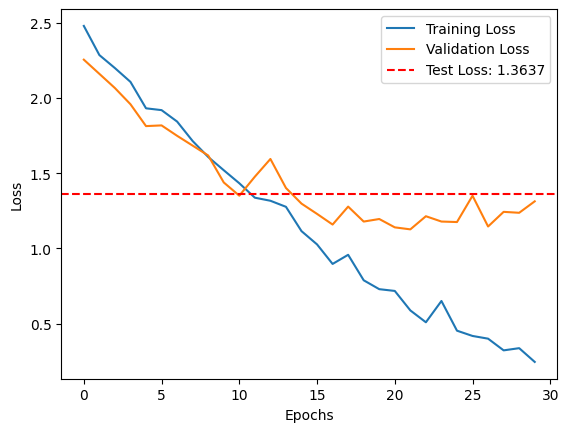

In [21]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_mini, y_test_mini)
print(f'Test accuracy: {test_acc}')

# Plot training loss, validation loss, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2. Repeat Step 1 after increasing the learning rate and adding one dropout layer anywhere between the
convolutional layers

# **1) MODEL DEVELOPMENT**

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

# Assuming vgg16_model is already defined and loaded with the VGG16 architecture
# You can load it using: vgg16_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()

# Iterate through the layers of VGG16 model
for i, layer in enumerate(vgg16_model.layers):
    # Add layers to the new model
    model.add(layer)

    # Add dropout layer after the first convolutional layer in Block 1
    if i == 1:
        model.add(Dropout(0.5))

# Display the summary of the new model

from tensorflow.keras.layers import Dense, Flatten, Dropout
model.add(Flatten())
model.add(Dense(512, activation='relu', name='hidden1'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu', name='hidden2'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax', name='predictions'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)        

In [9]:
sgd = optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy'])

In [10]:
def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
reduce_lr = LearningRateScheduler(lr_scheduler)

mc = ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# **2) TRAINING**

In [11]:
# initialize the number of epochs and batch size
EPOCHS = 30
BS = 70

# train the model
history = model.fit(
    x_train_mini,y_train_mini, batch_size=BS,
    validation_data=(x_valid_mini,y_valid_mini),
    steps_per_epoch=len(x_train_mini) // BS,
    epochs=EPOCHS,
    callbacks=[reduce_lr,mc])

Epoch 1/30
11/12 [==========================>...] - ETA: 0s - loss: 2.4271 - accuracy: 0.1208

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12/12 [==============================] - 10s 153ms/step - loss: 2.4141 - accuracy: 0.1226 - val_loss: 2.2806 - val_accuracy: 0.1500 - lr: 0.0010
Epoch 2/30
12/12 [==============================] - 4s 135ms/step - loss: 2.2977 - accuracy: 0.1205 - val_loss: 2.2108 - val_accuracy: 0.2433 - lr: 0.0010
Epoch 3/30
12/12 [==============================] - 1s 72ms/step - loss: 2.2221 - accuracy: 0.1783 - val_loss: 2.1480 - val_accuracy: 0.2467 - lr: 0.0010
Epoch 4/30
12/12 [==============================] - 1s 81ms/step - loss: 2.1498 - accuracy: 0.2072 - val_loss: 2.0730 - val_accuracy: 0.2867 - lr: 0.0010
Epoch 5/30
12/12 [==============================] - 1s 75ms/step - loss: 2.0622 - accuracy: 0.2289 - val_loss: 1.9366 - val_accuracy: 0.3467 - lr: 0.0010
Epoch 6/30
12/12 [==============================] - 1s 50ms/step - loss: 1.9530 - accuracy: 0.2747 - val_loss: 1.8609 - val_accuracy: 0.3267 - lr: 0.0010
Epoch 7/30
12/12 [==============================] - 2s 157ms/step - loss: 1.8502 - a

# **3) MODEL EVALUATION**

10/10 [==============================] - 0s 12ms/step - loss: 1.2089 - accuracy: 0.6333
Test accuracy: 0.6333333253860474


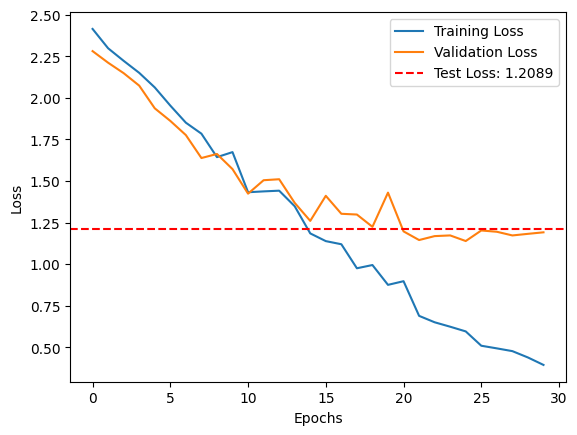

In [13]:
from matplotlib import pyplot as plt
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test_mini, y_test_mini)
print(f'Test accuracy: {test_acc}')

# Plot training loss, validation loss, and test loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

10/10 [==============================] - 0s 13ms/step - loss: 1.2089 - accuracy: 0.6333
Test accuracy: 0.6333333253860474


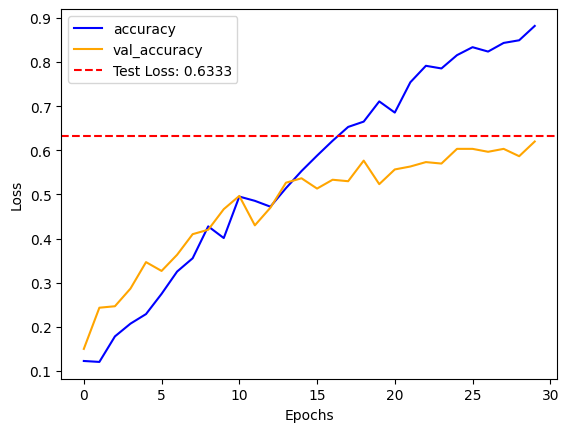

In [16]:
test_loss, test_acc = model.evaluate(x_test_mini, y_test_mini)
print(f'Test accuracy: {test_acc}')

plt.plot(history.history['accuracy'], color= 'blue', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Loss: {test_acc:.4f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()